In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint

In [3]:
file_path = 'base_20210101a20240430 (2).xlsx'
df = pd.read_excel(file_path, sheet_name='Cliientes_Nuevos')

In [4]:
variables_eliminar = ["montocredito_actual", "estatus_actual","diasatraso_actual","saldo_actual","prospectus_id"]
variables_ok = [i for i in df.columns if i not in variables_eliminar]
df = df[variables_ok]
df = df[df['es_malo_actual'].isin([0, 1])]
df = df.dropna()

In [7]:
y = df['es_malo_actual']
X = df.drop(columns=['es_malo_actual'])

In [9]:
X = X.select_dtypes(exclude=['datetime64'])
X = pd.get_dummies(X, drop_first=True)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [15]:
selector = SelectKBest(score_func=f_classif, k=20)  # Seleccionamos las 20 mejores características
X_selected = selector.fit_transform(X_balanced, y_balanced)

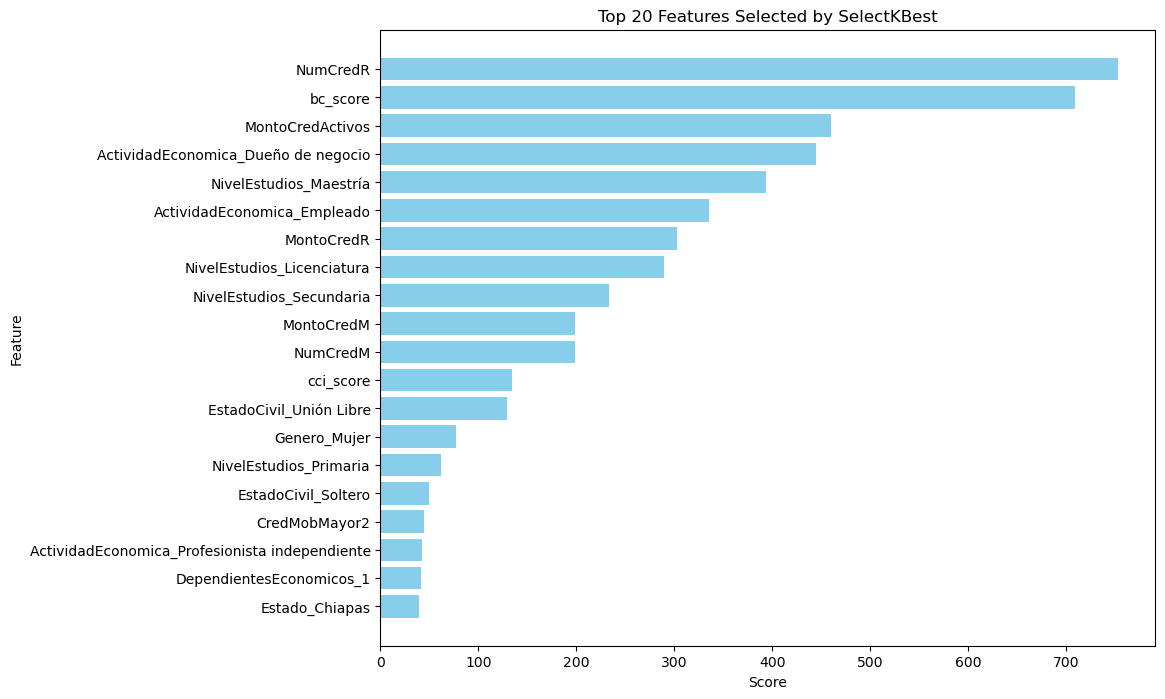

In [41]:
selected_features = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()
plt.show()


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_balanced, test_size=0.2, random_state=1234, stratify=y_balanced)

In [19]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

In [21]:
param_dist = {
    'Random Forest': {'n_estimators': randint(100, 300), 'max_depth': randint(10, 30), 'min_samples_split': randint(2, 10)},
    'Gradient Boosting': {'n_estimators': randint(100, 300), 'learning_rate': uniform(0.01, 0.2), 'max_depth': randint(3, 7)},
    'XGBoost': {'n_estimators': randint(100, 300), 'learning_rate': uniform(0.01, 0.2), 'max_depth': randint(3, 7)},
    'LightGBM': {'n_estimators': randint(100, 300), 'learning_rate': uniform(0.01, 0.2), 'max_depth': randint(3, 7)}
}

In [23]:
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    if name in param_dist:
        rand_search = RandomizedSearchCV(model, param_dist[name], cv=cv, scoring='roc_auc', n_iter=50, n_jobs=-1, random_state=42)
        rand_search.fit(X_train, y_train)
        best_models[name] = rand_search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_models[name] = model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22481, number of negative: 22482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4156
[LightGBM] [Info] Number of data points in the train set: 44963, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [24]:
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting']),
    ('xgb', best_models['XGBoost']),
    ('lgbm', best_models['LightGBM'])
], voting='soft')
voting_clf.fit(X_train, y_train)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_models['Random Forest']),
        ('gb', best_models['Gradient Boosting']),
        ('xgb', best_models['XGBoost']),
        ('lgbm', best_models['LightGBM'])
    ], final_estimator=LogisticRegression(max_iter=2000)
)
stacking_clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22481, number of negative: 22482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4156
[LightGBM] [Info] Number of data points in the train set: 44963, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=24,
                                                       min_samples_split=5,
                                                       n_estimators=298)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.052467822135655234,
                                                           max_depth=6,
                                                           n_estimators=287)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=241, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.05820509320520235,
                                               max_depth=6,
                                               n_estimators=298))],
                   final_estimator=LogisticRegression(max_iter=2000))

In [25]:
def evaluate_model(name, model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    end_time = time.time()

    auc_score = roc_auc_score(y_test, y_probs)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    training_time = end_time - start_time

    return {
        'Model': name,
        'ROC-AUC': auc_score,
        'Accuracy': acc_score,
        'F1-Score': f1,
        'Training Time (s)': training_time
    }

# Evaluación
results = []
for name, model in {**best_models, 'Voting Classifier': voting_clf, 'Stacking Classifier': stacking_clf}.items():
    results.append(evaluate_model(name, model, X_test, y_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [26]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False)
print(results_df)

                 Model   ROC-AUC  Accuracy  F1-Score  Training Time (s)
1        Random Forest  0.916573  0.852682  0.836234           1.293956
9  Stacking Classifier  0.916560  0.860689  0.845866           1.629214
8    Voting Classifier  0.914704  0.861222  0.840491           1.504544
2    Gradient Boosting  0.905862  0.860511  0.839640           0.124993
7             LightGBM  0.905694  0.861489  0.840716           0.094393
6              XGBoost  0.904163  0.859176  0.837791           0.013405
4                  KNN  0.781117  0.709545  0.710473           1.564289
3                  SVC  0.752693  0.678676  0.657695          74.838439
0  Logistic Regression  0.646474  0.603238  0.611701           0.002818
5          Naive Bayes  0.632991  0.568989  0.664450           0.017569


In [27]:
all_models = {}
for model_name, model in best_models.items():
    all_models[model_name] = model
all_models['Voting Classifier'] = voting_clf
all_models['Stacking Classifier'] = stacking_clf

In [28]:
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
best_tree_model_name = results_df[results_df['Model'].isin(tree_based_models)].iloc[0]['Model']
best_tree_model = all_models[best_tree_model_name]
print(f"El mejor modelo es: {best_tree_model_name}")

El mejor modelo es: Random Forest


In [29]:
y_probs = best_tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

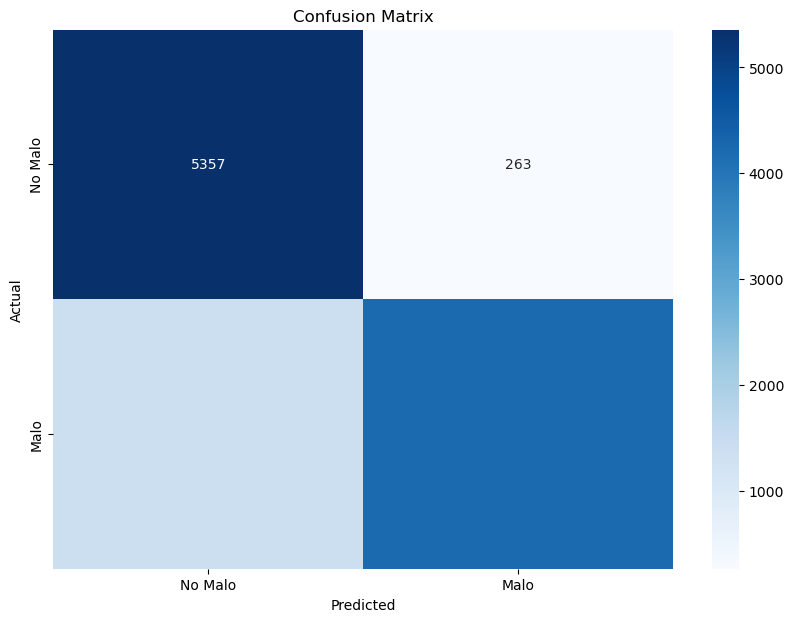

In [30]:
y_pred = best_tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

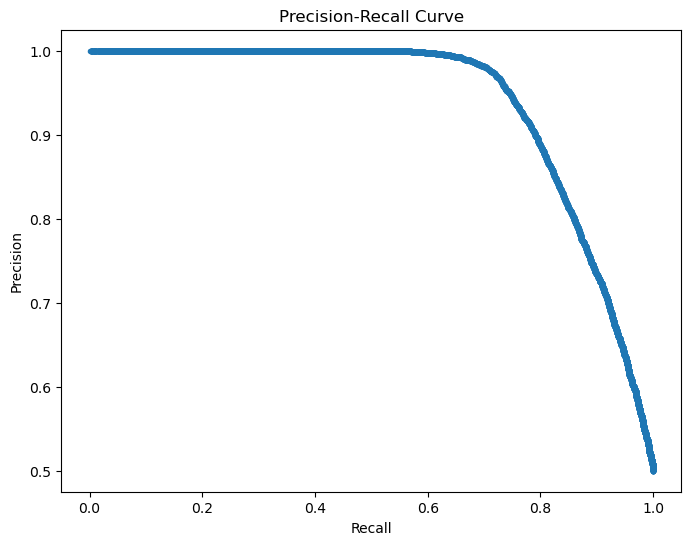

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()